# 데이콘 코드공유
## title : 전처리 및 CNN 코드 설계하기(진행중)(0.8694)
## Link : [데이콘](https://dacon.io/competitions/official/235874/codeshare/4567)

# 데이터 불러오기(학습 준비 단계)

### GPU 사용확인


In [5]:
import tensorflow as tf
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [1]:
import os 
import warnings
warnings.filterwarnings('ignore')

#GPU 할당
os.environ['CUDA_VISIBLE_DEVIES']= '0'

## 이미지 불러오기(baseline 코드)

In [100]:
from glob import glob
import numpy as np
import PIL
from PIL import Image

train_path = "C:/Users/User/Desktop/DataScience/data/object_image_classification_data/train/"
test_path = "C:/Users/User/Desktop/DataScience/data/object_image_classification_data/test/"
sub_path = "C:/Users/User/Desktop/DataScience/data/object_image_classification_data/sample_submission.csv"

In [101]:
#훈련데이터 로드
from sklearn.preprocessing import LabelEncoder
def load_train(path):
    images = []
    labels = []
    for file_name in glob(path + "*"):
        for img in glob(file_name + "/*.jpg"):
            an_img = PIL.Image.open(img) #read img
            img_array = np.array(an_img) #img to array
            images.append(img_array) #append array to traing_images
            label = file_name.split("train\\")[1] #get label
            labels.append(label) # append label
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

train_images, train_labels = load_train(train_path)

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
train_labels = train_labels.reshape(-1,1)

print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


50000개의 train image가 존재합니다.

In [102]:
#테스트 데이터 로드
def load_test(path):
    test_images = []
    test_idx = []
    file_list = sorted(glob(path + "*.jpg"))
    for file_name in file_list:
        img = PIL.Image.open(file_name) #read img
        img_array = np.array(img) # img to array
        test_images.append(img_array) # append array to testing_images
        
        label = file_name.split("\\")[1]
        test_idx.append(label)
    test_images = np.array(test_images)
    return test_images, test_idx

test_images, test_index = load_test(test_path)
print(test_images.shape)
print(test_index[:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


10000개의 테스트 이미지가 존재합니다.

### 이미지 확인하기

[0],[0],[1],[1],[2],[2],[3],[3],[4],[4],[5],[5],[6],[6],[7],[7],[8],[8],[9],[9],

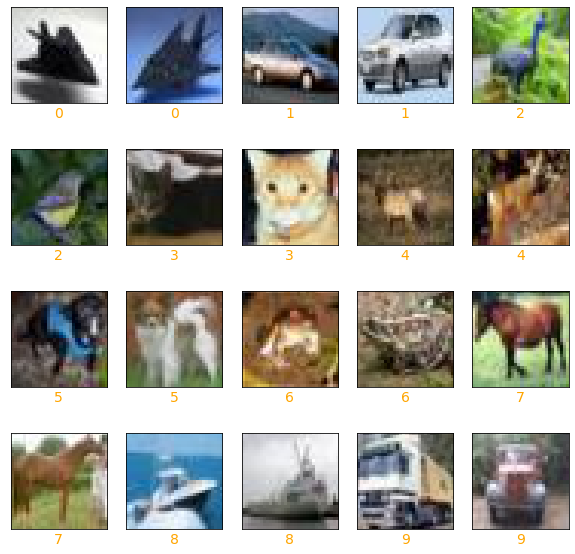

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
for i in range(20):
    ax= plt.subplot(4,5,i+1)    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i*2500])
    ax.xaxis.label.set_color('orange')
    ax.xaxis.label.set_fontsize(14)
    plt.xlabel(train_labels[i*2500][0])
    print(train_labels[i*2500], end=',')

plt.show()

In [61]:
label_num = [0,1,2,3,4,5,6,7,8,9]
label_name = le.inverse_transform(label_num)

for i in range(10):
    print(label_num[i], label_name[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


# 데이터 전처리
## data augmentation을 통한 데이터 생성

data augmentation은 data set의 개수를 늘려서 overfitting을 해결하기 위해 등장한 개념입니다.  
생성된 샘플은 가능한 진짜에 가까워야 하기 때문에 data의 특성에 따라서 augmentation을 조절해주어 모델이 잘 학습할 수 있도록 해야합니다.  
keras에서 제공하는 ImageDataGenerator 함수를 사용하여 데이터를 생성하겠습니다.

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    #이미지를 랜덤한 각도로 돌리는 정도
    rotation_range=30,
    #이미지의 밝기를 랜덤하게 다르게 주는 정도
    brightness_range=[0.8, 1.0],
    #사진을 확대하는 정도
    zoom_range=0.3,
    #사진을 왼쪽 오른쪽으로 움직이는 정도
    width_shift_range=0.2,
    #사진을 위 아래로 움직이는 정도
    height_shift_range=0.2,
    #y축을 기준으로 반전(오른쪽 왼쪽 뒤집기)
    horizontal_flip=True,
    #x축을 기준으로 반전(위 아래 뒤집기)
    vertical_flip=False
)

vertival_filp을 False로 한 이유는 생성된 샘플이 가능한 진짜에 가까워야하기 때문에  
자동차 같은 경우 바퀴가 위로간 자동차의 형태가 생성이 되기 때문에  
일반적인 자동차판단에 좋지 않은 영향이 끼치게 될것 같아서 제외했습니다.  

### data augmentation 살펴보기

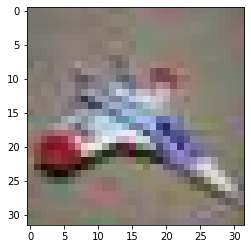

In [104]:
sample_image = train_images[1]
plt.imshow(sample_image.astype('uint8'))
sample_image = np.expand_dims(sample_image, 0)
plt.show()

In [105]:
sample_image_it = image_generator.flow(sample_image, batch_size=1)

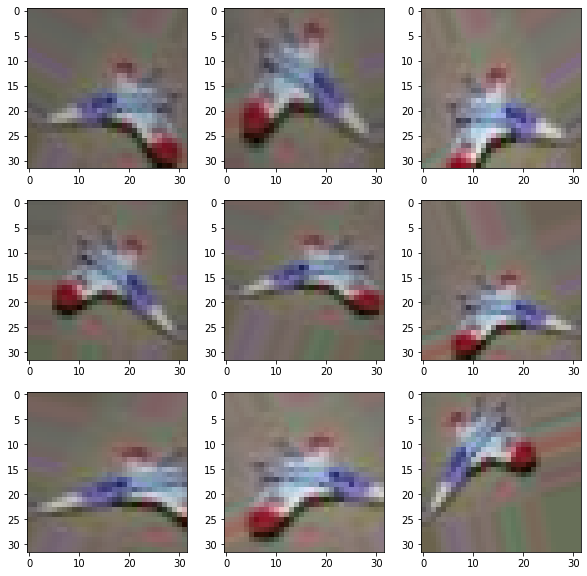

In [106]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    batch = sample_image_it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

동작 하는것을 확인했으니 augmentation을 적용

In [107]:
auugment_size = 100000
random_mask = np.random.randint(train_images.shape[0], size=auugment_size)
train_images_aug = train_images[random_mask].copy()
train_labels_aug = train_labels[random_mask].copy()

print(train_images_aug.shape)
print(train_labels_aug.shape)

(100000, 32, 32, 3)
(100000, 1)


In [108]:
train_images_aug = image_generator.flow(train_images_aug, np.zeros(auugment_size), batch_size=auugment_size, shuffle=False).next()[0]

train_images = np.concatenate((train_images, train_images_aug))
train_labels = np.concatenate((train_labels, train_labels_aug))

In [109]:
print(train_images.shape)
print(train_labels.shape)

(150000, 32, 32, 3)
(150000, 1)
